In [3]:
%matplotlib inline

Example of processing steps to create trial-unique beta maps from the CIMAQ fMRI data 
(memory task: image encoding), illustrated within a single subject:

The outputed beta maps are meant to be fed as features to a within-subject nilearn classifier.

Input:
    - task (event) files generated from raw eprime (.txt) outputs and organized into .tsv file 
    by cimaq_convert_eprime_to_bids_event.py script
    - confound (motion, etc) files generated from Niak preprocessing
    pipeline (confounds.tsv) 
    - preprocessed Niak data (4D .nii file found under resample; note: data are not smoothed)
Output: one map (3D .nii file) of beta (regression) weights for each trial, and one 
concatenated 4D file of these 3D maps (trials ordered chronologically).

Note: comparing two different ways to model trials of no interest
version 1: a separate model is built for each trial, with the trial of interest modelled as a separate condition (1 regressor), and all the other trials modelled in either the Encoding or Control condition (2 regressors)
**Update: betas from version 1 lead to much better enc/ctl trial classification**
version 2: a separate model is built for each trial, with the trial of interest modelled as a separate condition (1 regressor), and all the other trials modelled as a single "other" condition (1 regressor)
**Update: betas from version2 lead to poorer enc/ctl trial classification**

Reference: how to derive beta maps for MVPA classification (Mumford et al., 2012):
https://www.sciencedirect.com/science/article/pii/S1053811911010081

Also creating contrasts per condition (to derive features for between-subject classification): 
- a model that models enconding and control conditions across trials 
(3 beta maps: encoding (enc) , control (ctl), and encoding minus control (enc_minus_ctl)
- a model that models the control condition, as well as the encoding condition according to task performance : miss and hit (post-scan image recognition performance)
(5 beta maps: miss (miss), hit (hit), hit minus miss (hit_minus_miss), hit minus control
(hit_minus_ctl), miss minus control (miss_minus_ctl)
- a model that models the control condition, as well as the encoding condition according to task performance : miss, wrong source, and correct source.
(7 beta maps: wrong source (wrong_source), correct source (corr_source), correct source minus wrong source (cs_minus_ws), correct source minus miss (cs_minus_miss), wrong source minus miss (ws_minus_miss), correct source minus control (cs_minus_ctl), and wrong source minus control (ws_minus_ctl)


In [4]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import nilearn
import nistats
import scipy
import nibabel

from numpy import nan as NaN
from matplotlib import pyplot as plt
from nistats.reporting import plot_design_matrix
from nistats.first_level_model import FirstLevelModel
from nistats.design_matrix import make_first_level_design_matrix
from nilearn import image, plotting
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show

#libraries need to be installed in conda environment with pip install

Step 1: Load confound parameters outputed from the NIAK preprocessing pipeline (slow signal drift, motion parameters, mean white matter and mean ventricle signal intensity)

**Note: The full NIAK preprocessing pipeline scrubs (regresses out) motion outlier frames, which may not be compatible with other software like Nilearn or Nistats.
Intermediate data from the preprocessing pipeline should be used that have been slice-timed, co-registered and resampled (motion-corrected).  

These data are found under the **resample** directory (not under fMRI), in .nii format, with accompanying _extra.mat and confounds.tsv.gz files. 
These data have undergone **no smoothing**, and confounds have NOT been regressed out. 

Use gunzip *gz command to unzip .tsv files inside working directory

**Update: the nistats first-level model can model some of the slow drift and noise parameters (not used here). Here, I use all the confounds in *counfounds.tsv (including slow drift) as regressors, so I don't model slow drift, etc in the first-level model (it's redundant). 


In [5]:
#specify subject DCCID (6-digit identifier, in Loris-cimaq)
id = '122922' #this subject has 310 frames, few scrubbed frames, good data, and
# good balance of missed (23 trials), wrong source (30 trials) and correct source (25 trials)
#id = '763590' #this subject has 288 frames

#specify path to directory with *confound.tsv file
motion_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/MotionFiles/motion_resample/fromNIAK'
subject_motion = glob.glob(os.path.join(motion_dir, 'fmri_sub'+id+'*confounds.tsv'))[0]

#load counfounds file as pandas dataframe 
confounds = pd.read_csv(subject_motion, sep='\t')

#scan duration, in seconds : number of fMRI frames (~310), times TR = 2.5s
scanDur = confounds.shape[0]*2.5

print(scanDur)


775.0


In [ ]:
##Not used in most current model##
#create "short" counfounds dataframe with only a subset of confounds
#these counfounds are to be used if slow drift, etc is modelled in nistats rather than niak
short_counfounds = confounds.copy(deep = True)

#select which columsn from NIAK counfounds.tsv file to include in first-level Nistats model 
#(when modelling slow-drift and other junk parameters within Nistats instead of NIAK)
colsKeep = ['motion_tx', 'motion_ty', 'motion_tz', 'motion_rx', 
            'motion_ry', 'motion_rz', 'scrub', 'wm_avg', 'vent_avg']

cols = confounds.columns

#remove columns not in list of colums to keep (colsKeep)
for i in cols:
    if (i in colsKeep)==False:
        short_counfounds.drop([i], axis=1, inplace=True)    

Step 2: create events variable, and events.tsv file from the 'sub-*_ses-4_task-memory_events.tsv' task file outputed by the cimaq_convert_eprime_to_bids_event.py script 

Number of rows = number of trials (the first-level model will use onset times to match conditions (trials) with fMRI frames).

Documentation:
https://nistats.github.io/auto_examples/04_low_level_functions/write_events_file.html#sphx-glr-auto-examples-04-low-level-functions-write-events-file-py

Each encoding trial is modelled as a different condition (under trial_type column) so that it is modelled separately when creating the design matrix. The trial has its own column in the design matrix; the other columns = other trials (modelled together as single regressor), and confound regressors.

**Note: Some scans were cut short, meaning that the last few trials do not have associated brain activation frames, and they need to be left out of the analysis; 310 frames = full scan, 288 frames = incomplete (~15 participants).
"unscanned" trials need to be excluded from the model (about ~2-4 trials missing).
288*2.5 = 720s. 
Trial #115 (out of 117) offset time ~ 710s
Trial #116 (out of 117) onset ~ 723s

In [6]:
#specify path to directory with task files (eventually on Stark)
task_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/TaskFiles/Processed'

#specify output directory
outTask_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Events'

subject_task = glob.glob(os.path.join(task_dir, 'sub-'+id+'*tsv'))[0]

#load subject's task data as pandas DataFrame 
s_task = pd.read_csv(subject_task, sep='\t')

#rename "trial_type" column as "condition"
s_task.rename(columns={'trial_type':'condition'}, inplace=True)

#add columns to DataFrame
numCol = s_task.shape[1] 
insertCol = [4, numCol+1, numCol+2, numCol+3]
colNames = ['trial_type', 'unscanned', 'ctl_miss_hit', 'ctl_miss_ws_cs']
colVals = ['TBD', 0, 'TBD', 'TBD']
for i in range(0, len(colNames)):
    s_task.insert(loc=insertCol[i], column=colNames[i], value=colVals[i], allow_duplicates=True)

#The 'unscanned' column flag trials for which no brain data was acquired.
#The scan's duration is shorter than the trial's offset time
#(0 = data, 1 = no data)
for j in s_task[s_task['offset']>scanDur].index:
    s_task.loc[j, 'unscanned']=1

#pas trial numbers with zeros (on the left) to preserve trial 
#temporal order when trials are alphabetized
s_task['trial_number'] = s_task['trial_number'].astype('object',
                                                       copy=False)
for k in s_task.index:
    s_task.loc[k, 'trial_number'] = str(s_task.loc[k, 'trial_number']).zfill(3)

#trial_type should have a unique entry per row so that each trial 
#can be modelled as a separate condition
countEnc = 0
countCTL = 0
for m in s_task[s_task['condition']=='Enc'].index:
    countEnc = countEnc + 1
    s_task.loc[m, 'trial_type'] = 'Enc'+str(countEnc)
    if s_task.loc[m, 'position_accuracy'] == 0:
        s_task.loc[m, 'ctl_miss_hit']='missed'
        s_task.loc[m, 'ctl_miss_ws_cs']='missed'
    elif s_task.loc[m, 'position_accuracy'] == 1:
        s_task.loc[m, 'ctl_miss_hit']='hit'
        s_task.loc[m, 'ctl_miss_ws_cs']='wrongsource'
    elif s_task.loc[m, 'position_accuracy'] == 2:
        s_task.loc[m, 'ctl_miss_hit']='hit'
        s_task.loc[m, 'ctl_miss_ws_cs']='correctsource' 
for n in s_task[s_task['condition']=='CTL'].index:
    countCTL = countCTL + 1
    s_task.loc[n, 'trial_type'] = 'CTL'+str(countCTL)
    s_task.loc[n, 'ctl_miss_hit']='control'
    s_task.loc[n, 'ctl_miss_ws_cs']='control'

#78 encoding and 39 control trials if full scan
print('Number of encoding trials:  ', countEnc)
print('Number of control trials:  ', countCTL)

#Export Dataframe to events.tsv file    
s_task.to_csv(outTask_dir+'/sub-'+id+'_events.tsv',
              sep='\t', header=True, index=False)
    
#keep only trials for which fMRI data was collected
s_task = s_task[s_task['unscanned']==0]

#Save vectors of trial labels (e.g., encoding vs control)
#to label trials for classification analyses
ttypes1 = s_task['condition']
ttypes1.to_csv(outTask_dir+'/sub-'+id+'_enco_ctl.tsv',
              sep='\t', header=True, index=False)

ttypes2 = s_task['ctl_miss_hit']
ttypes2.to_csv(outTask_dir+'/sub-'+id+'_ctl_miss_hit.tsv',
              sep='\t', header=True, index=False)

ttypes3 = s_task['ctl_miss_ws_cs']
ttypes3.to_csv(outTask_dir+'/sub-'+id+'_ctl_miss_ws_cs.tsv',
              sep='\t', header=True, index=False)


#from s_task dataframe, create an events dataframe to create a design matrix 
#that will be inputed into a first-level model in nistats
ev_cols = ['onset', 'duration', 'trial_type', 'condition', 'ctl_miss_hit', 
           'ctl_miss_ws_cs', 'trial_number']
all_events = s_task[ev_cols]  

print(all_events.shape)
print(all_events.iloc[0:30, :])


Number of encoding trials:   78
Number of control trials:   39
(117, 7)
      onset  duration trial_type condition ctl_miss_hit ctl_miss_ws_cs  \
0    25.027     3.009       Enc1       Enc          hit  correctsource   
1    28.537     3.009       CTL1       CTL      control        control   
2    32.048     3.009       Enc2       Enc          hit    wrongsource   
3    39.553     3.009       Enc3       Enc          hit    wrongsource   
4    44.552     3.009       CTL2       CTL      control        control   
5    51.054     3.009       CTL3       CTL      control        control   
6    55.551     3.009       Enc4       Enc       missed         missed   
7    61.051     3.009       Enc5       Enc          hit    wrongsource   
8    65.063     3.009       CTL4       CTL      control        control   
9    71.064     3.009       Enc6       Enc          hit  correctsource   
10   78.068     3.009       CTL5       CTL      control        control   
11   81.579     3.008       Enc7       E

**Step3 : Implement first-level model (implements regression in nistats), generate contrasts and output maps of beta values (parameter estimators; one map of betas per trial).

**About first-level model:

Note 1: nistats.first_level_model provides an interface to use the glm implemented in nistats.regression

Note 2: each encoding trial is modelled as a separate condition to obtain separate maps of beta values (model's output type to get betas = **effect sizes** (Nistats name), aka parameter estimates)

**UPDATE: a separate model is created to obtain a beta map for each trial. 
The trial of interest is modelled as a unique condition (it has its own column in the design matrix), and the other trials are modelled together.
Version A: beside the trial of interest (1 regressor), the control trials and encoding trials are modelled separately (2 regressors)
Version B: beside the trial of interest (1 regressor), the control trials and encoding trials are modelled together as a single "other_trials" condition (1 regressor)

Note 3: the first_level_model can either be given a pre-constructed **design matrix** (built from the events and confounds files in a separate preparatory step) as a parameter, or be given the **events and confounds** files directly as parameters (skipping the need to create a design matrix in a separate step). In the second situation, the model will generate and output the design matrix.  

As a parameter to the first-level-model, the design matrix takes precedence over the events and confounds parameters.

Nistats link on design matrices:
https://nistats.github.io/auto_examples/04_low_level_functions/plot_design_matrix.html

https://nistats.github.io/modules/generated/nistats.design_matrix.make_first_level_design_matrix.html

Example where the design matrix is created directly within the first level model interface by inputing events and confounds files directly as parameters (I'm not doing that here): https://nistats.github.io/auto_examples/01_tutorials/plot_first_level_model_details.html#running-a-basic-model

CHOSEN: 2-step method. Create design matrix directly from events file and confounds outputed from NIAK (resample directory), then generate and fit first-level-model

**About contrasts and maps of beta values (parameter estimators):

When each trial is modeled as a separate condition, it is represented as its own column in the design matrix. 

To access the estimated coefficients (betas of the GLM model), we need to specify "canonical contrasts" (one per trial) that isolate design matrix columns (each contrast has a single 1 in its corresponding colum, and 0s for all the other columns).

Sources of info: how to extract beta maps in nistats (instructions are a bit obscure)
https://15-35545854-gh.circle-artifacts.com/0/home/ubuntu/nistats/doc/_build/html/auto_examples/plot_spm_auditory.html
https://github.com/poldracklab/fitlins/pull/48
https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html#nistats.first_level_model.FirstLevelModel


**Version A: A separate model created for each trial.
Trial of interest modelled as its own condition, and other trials are modelled as two conditions: control, and encoding (excluding trial of interest)


004   Enc1   Index(['Enc1', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


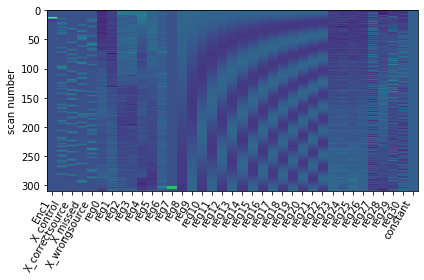

betas_sub122922_Trial004_Enc1.nii
005   CTL1   Index(['CTL1', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


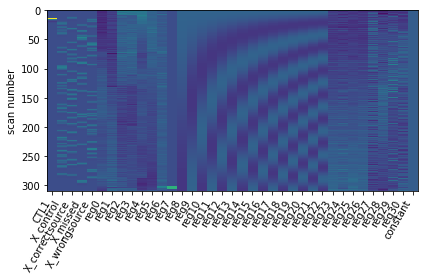

betas_sub122922_Trial005_CTL1.nii
006   Enc2   Index(['Enc2', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


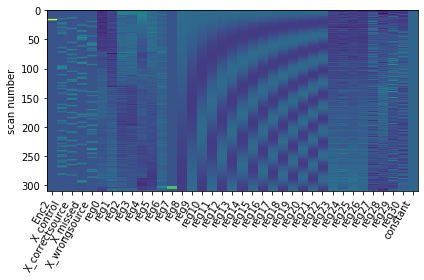

betas_sub122922_Trial006_Enc2.nii
007   Enc3   Index(['Enc3', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


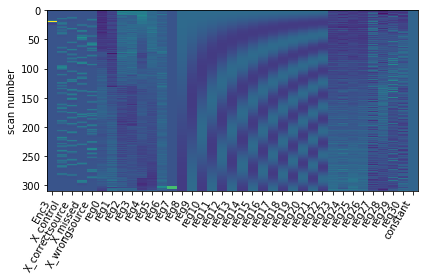

betas_sub122922_Trial007_Enc3.nii
008   CTL2   Index(['CTL2', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


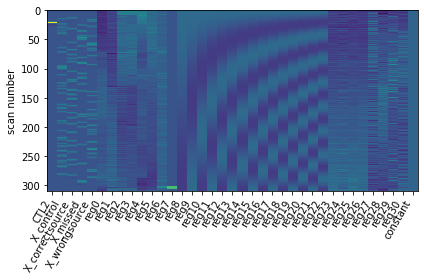

betas_sub122922_Trial008_CTL2.nii
009   CTL3   Index(['CTL3', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


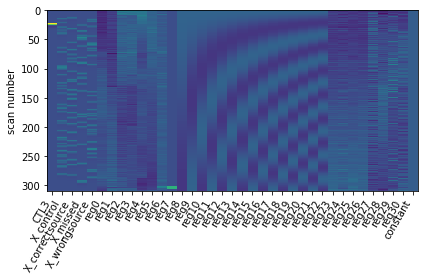

betas_sub122922_Trial009_CTL3.nii
010   Enc4   Index(['Enc4', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


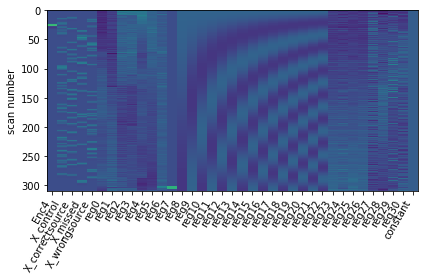

betas_sub122922_Trial010_Enc4.nii
011   Enc5   Index(['Enc5', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


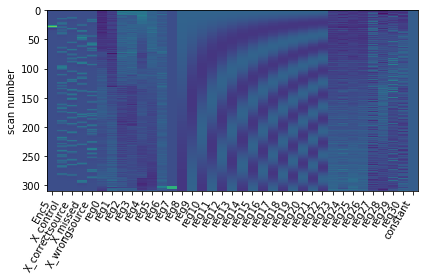

betas_sub122922_Trial011_Enc5.nii
012   CTL4   Index(['CTL4', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


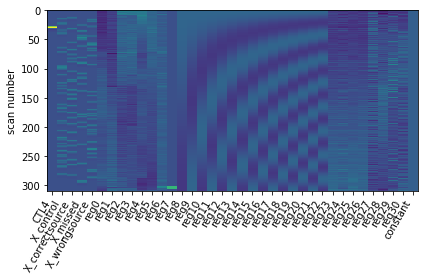

betas_sub122922_Trial012_CTL4.nii
013   Enc6   Index(['Enc6', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


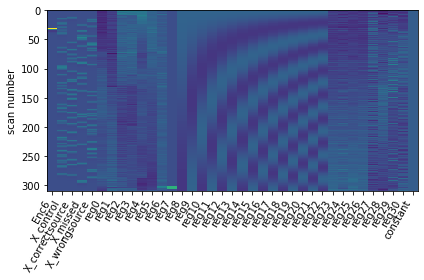

betas_sub122922_Trial013_Enc6.nii
014   CTL5   Index(['CTL5', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


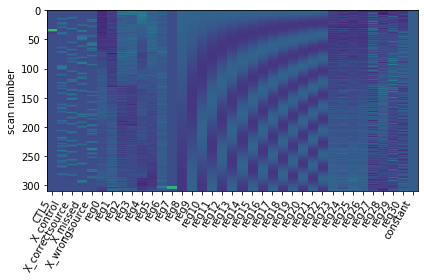

betas_sub122922_Trial014_CTL5.nii
015   Enc7   Index(['Enc7', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


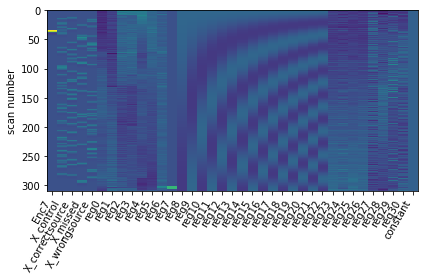

betas_sub122922_Trial015_Enc7.nii
016   CTL6   Index(['CTL6', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


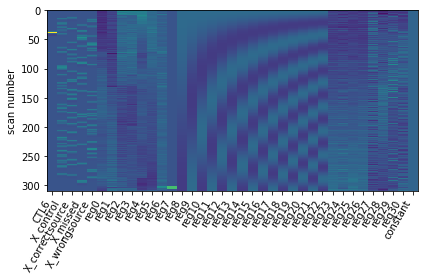

betas_sub122922_Trial016_CTL6.nii
017   CTL7   Index(['CTL7', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


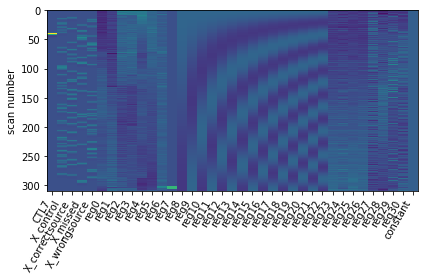

betas_sub122922_Trial017_CTL7.nii
018   Enc8   Index(['Enc8', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


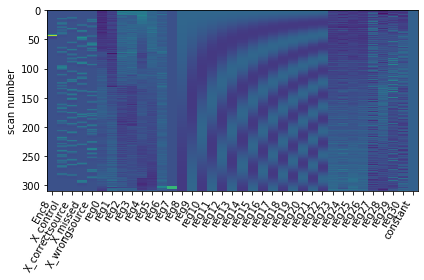

betas_sub122922_Trial018_Enc8.nii
019   Enc9   Index(['Enc9', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


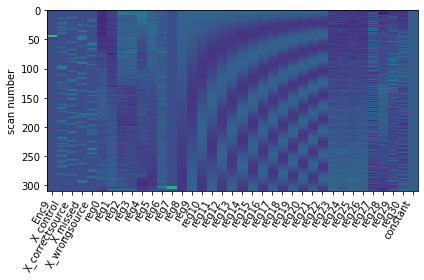

betas_sub122922_Trial019_Enc9.nii
020   Enc10   Index(['Enc10', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


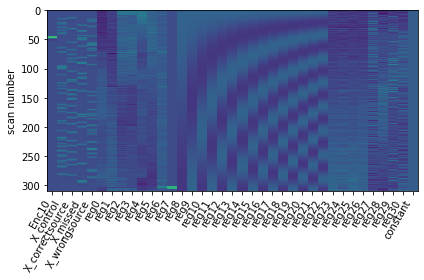

betas_sub122922_Trial020_Enc10.nii
021   Enc11   Index(['Enc11', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


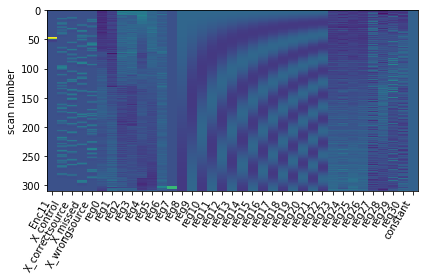

betas_sub122922_Trial021_Enc11.nii
022   Enc12   Index(['Enc12', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


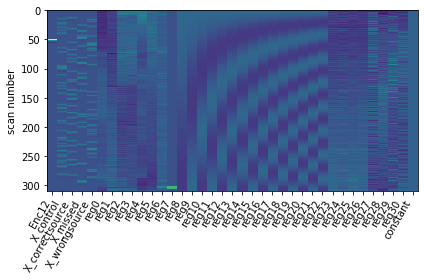

betas_sub122922_Trial022_Enc12.nii
023   Enc13   Index(['Enc13', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


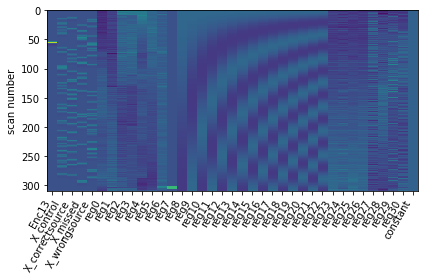

betas_sub122922_Trial023_Enc13.nii
024   Enc14   Index(['Enc14', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


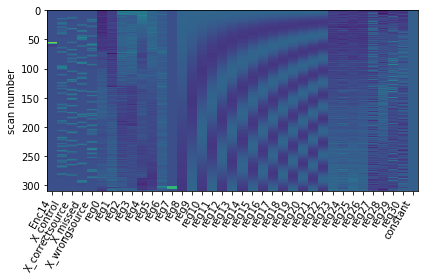

betas_sub122922_Trial024_Enc14.nii
025   Enc15   Index(['Enc15', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


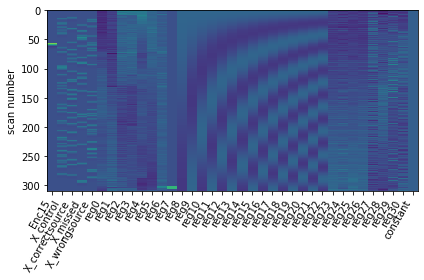

betas_sub122922_Trial025_Enc15.nii
026   Enc16   Index(['Enc16', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


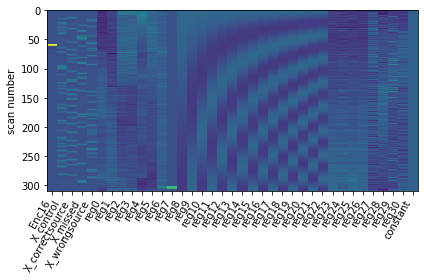

betas_sub122922_Trial026_Enc16.nii
027   Enc17   Index(['Enc17', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


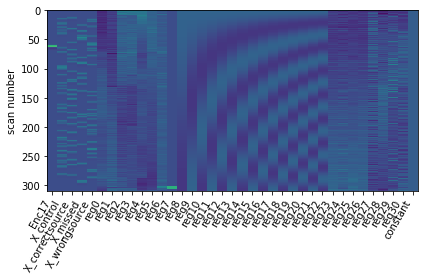

betas_sub122922_Trial027_Enc17.nii
028   CTL8   Index(['CTL8', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


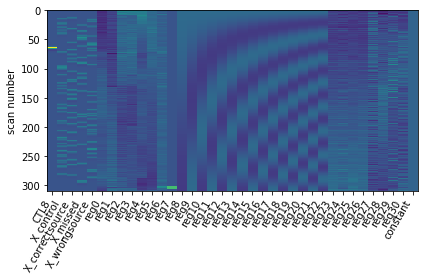

betas_sub122922_Trial028_CTL8.nii
029   Enc18   Index(['Enc18', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


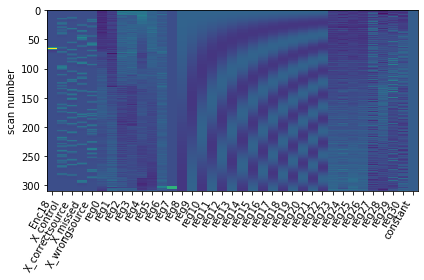

betas_sub122922_Trial029_Enc18.nii
030   Enc19   Index(['Enc19', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


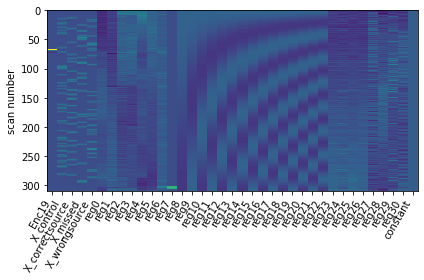

betas_sub122922_Trial030_Enc19.nii
031   Enc20   Index(['Enc20', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


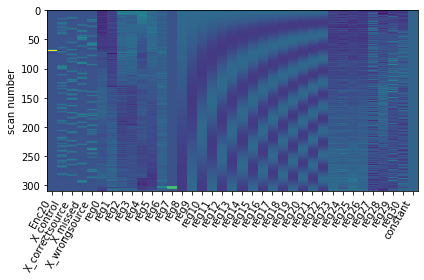

betas_sub122922_Trial031_Enc20.nii
032   CTL9   Index(['CTL9', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


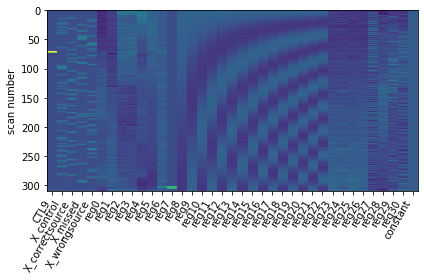

betas_sub122922_Trial032_CTL9.nii
033   Enc21   Index(['Enc21', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


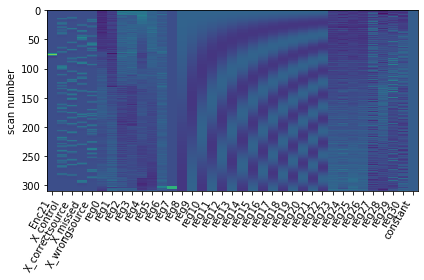

betas_sub122922_Trial033_Enc21.nii
034   Enc22   Index(['Enc22', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


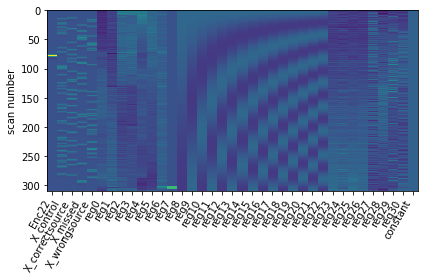

betas_sub122922_Trial034_Enc22.nii
035   Enc23   Index(['Enc23', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


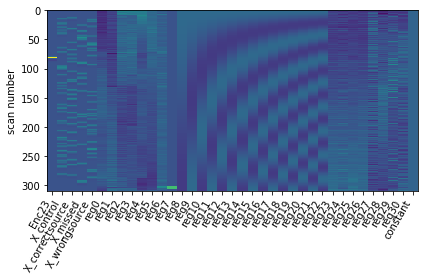

betas_sub122922_Trial035_Enc23.nii
036   Enc24   Index(['Enc24', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


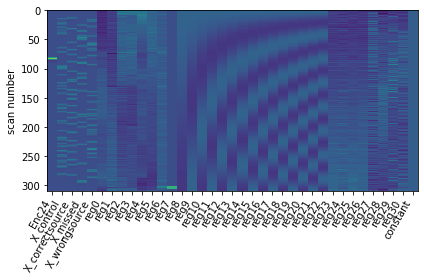

betas_sub122922_Trial036_Enc24.nii
037   Enc25   Index(['Enc25', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


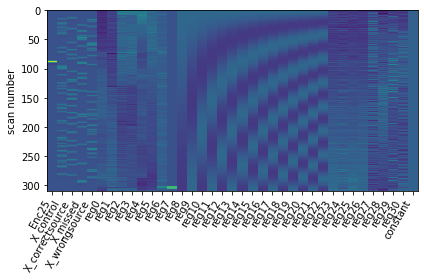

betas_sub122922_Trial037_Enc25.nii
038   Enc26   Index(['Enc26', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


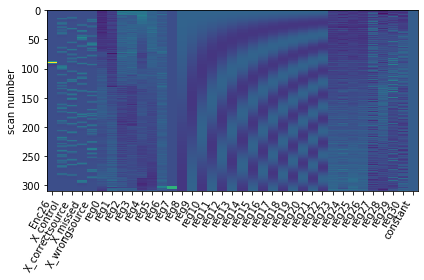

betas_sub122922_Trial038_Enc26.nii
039   Enc27   Index(['Enc27', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


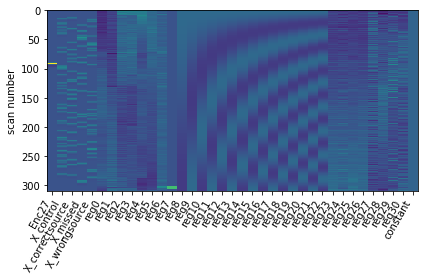

betas_sub122922_Trial039_Enc27.nii
040   Enc28   Index(['Enc28', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


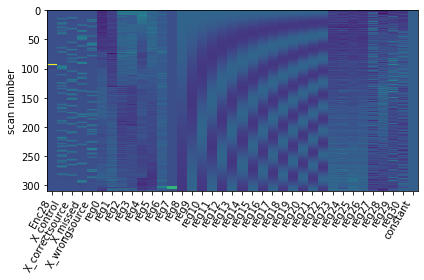

betas_sub122922_Trial040_Enc28.nii
041   CTL10   Index(['CTL10', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


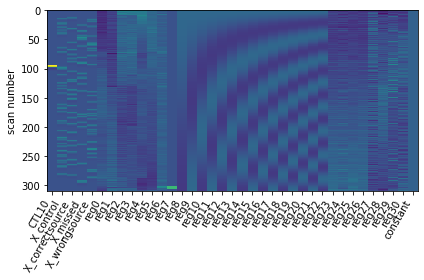

betas_sub122922_Trial041_CTL10.nii
042   CTL11   Index(['CTL11', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


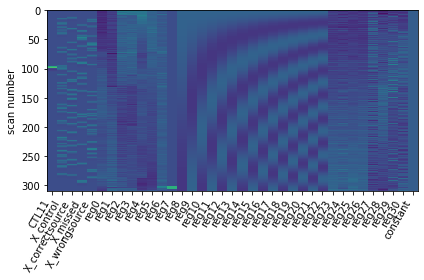

betas_sub122922_Trial042_CTL11.nii
043   CTL12   Index(['CTL12', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


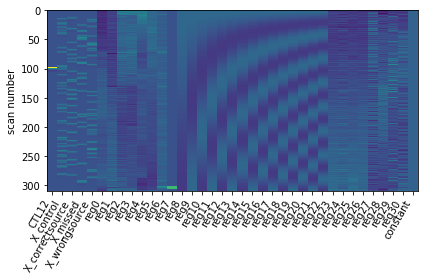

betas_sub122922_Trial043_CTL12.nii
044   CTL13   Index(['CTL13', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


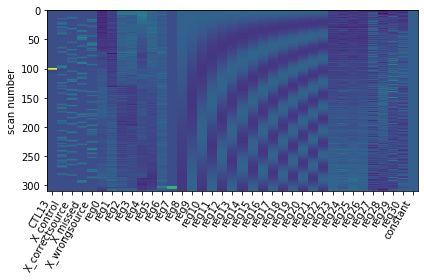

betas_sub122922_Trial044_CTL13.nii
045   Enc29   Index(['Enc29', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


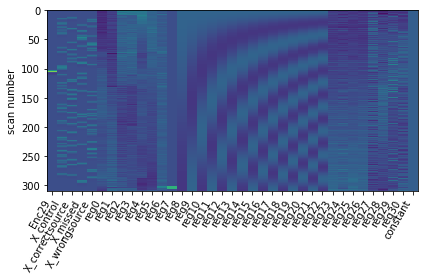

betas_sub122922_Trial045_Enc29.nii
046   Enc30   Index(['Enc30', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


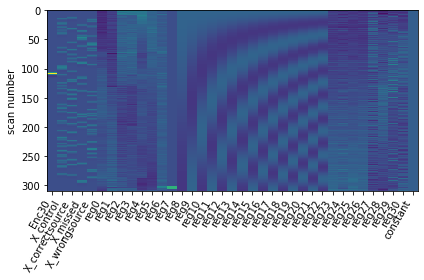

betas_sub122922_Trial046_Enc30.nii
047   CTL14   Index(['CTL14', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


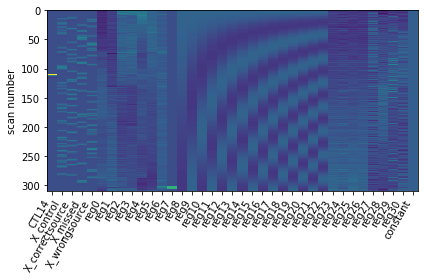

betas_sub122922_Trial047_CTL14.nii
048   Enc31   Index(['Enc31', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


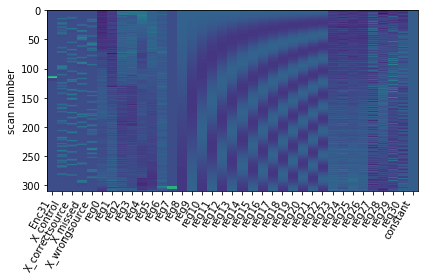

betas_sub122922_Trial048_Enc31.nii
049   Enc32   Index(['Enc32', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


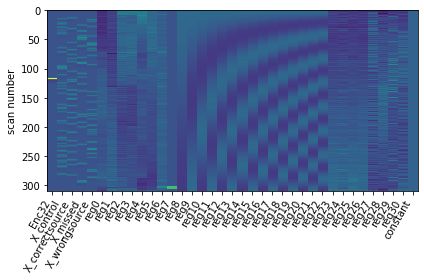

betas_sub122922_Trial049_Enc32.nii
050   Enc33   Index(['Enc33', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


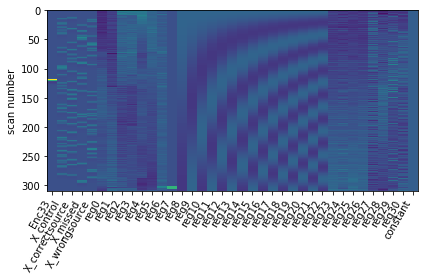

betas_sub122922_Trial050_Enc33.nii
051   Enc34   Index(['Enc34', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


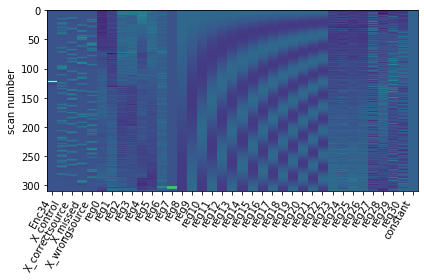

betas_sub122922_Trial051_Enc34.nii
052   CTL15   Index(['CTL15', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


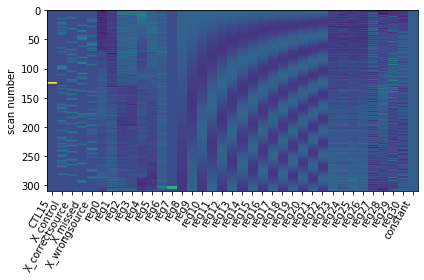

betas_sub122922_Trial052_CTL15.nii
053   Enc35   Index(['Enc35', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


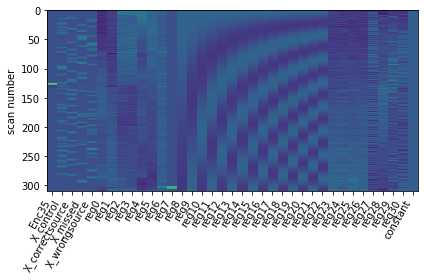

betas_sub122922_Trial053_Enc35.nii
054   CTL16   Index(['CTL16', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


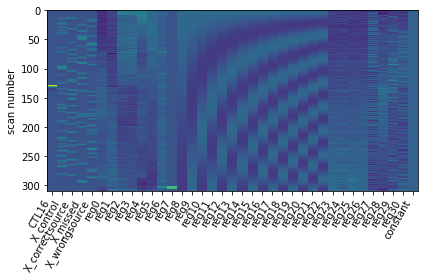

betas_sub122922_Trial054_CTL16.nii
055   CTL17   Index(['CTL17', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


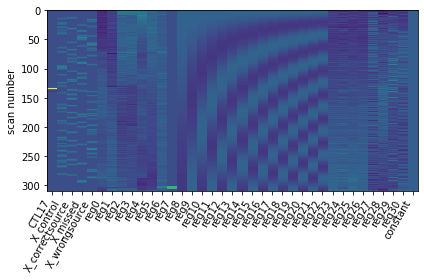

betas_sub122922_Trial055_CTL17.nii
056   Enc36   Index(['Enc36', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


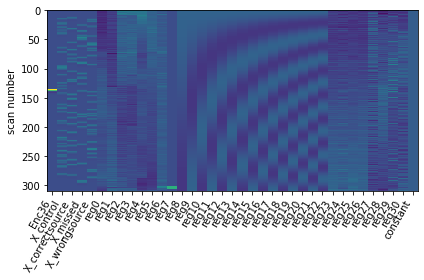

betas_sub122922_Trial056_Enc36.nii
057   Enc37   Index(['Enc37', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


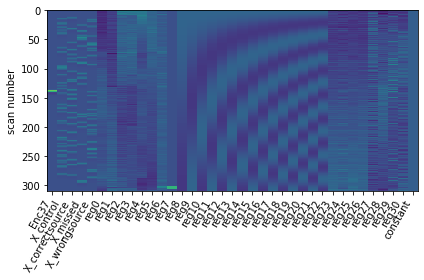

betas_sub122922_Trial057_Enc37.nii
058   Enc38   Index(['Enc38', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


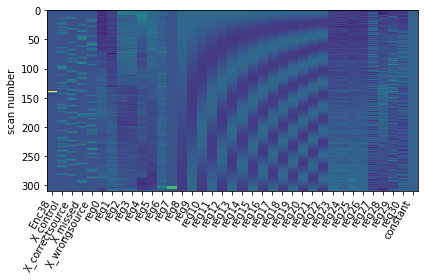

betas_sub122922_Trial058_Enc38.nii
059   CTL18   Index(['CTL18', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


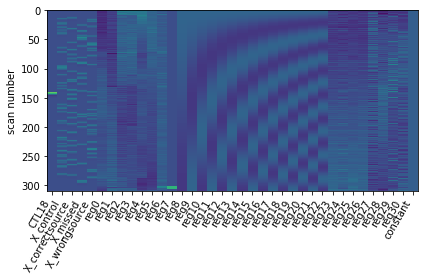

betas_sub122922_Trial059_CTL18.nii
060   Enc39   Index(['Enc39', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


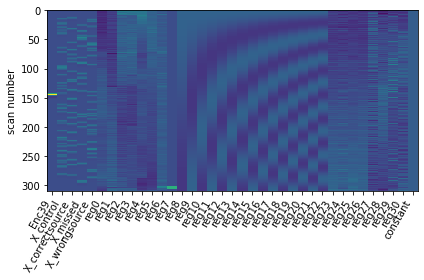

betas_sub122922_Trial060_Enc39.nii
061   Enc40   Index(['Enc40', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


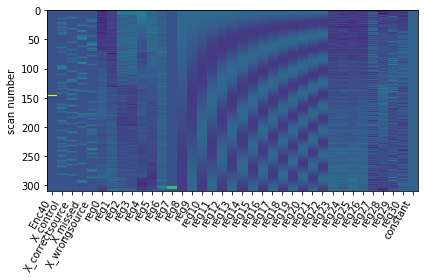

betas_sub122922_Trial061_Enc40.nii
062   Enc41   Index(['Enc41', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


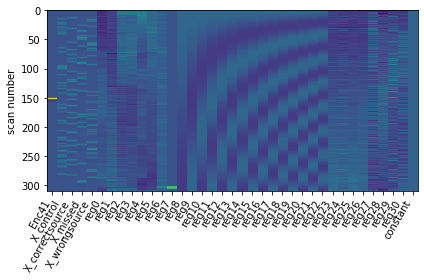

betas_sub122922_Trial062_Enc41.nii
063   Enc42   Index(['Enc42', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


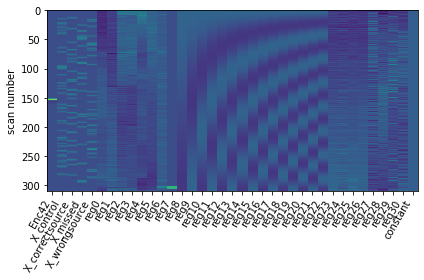

betas_sub122922_Trial063_Enc42.nii
064   Enc43   Index(['Enc43', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


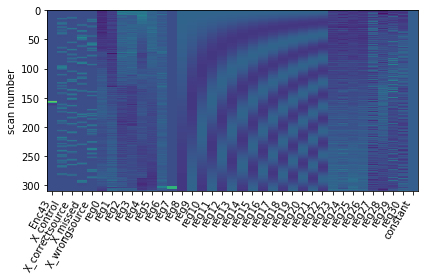

betas_sub122922_Trial064_Enc43.nii
065   CTL19   Index(['CTL19', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


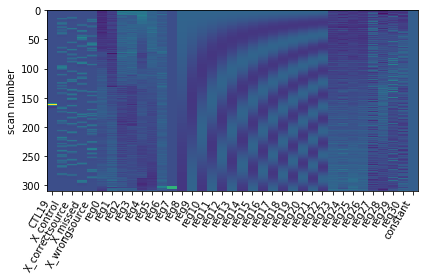

betas_sub122922_Trial065_CTL19.nii
066   Enc44   Index(['Enc44', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


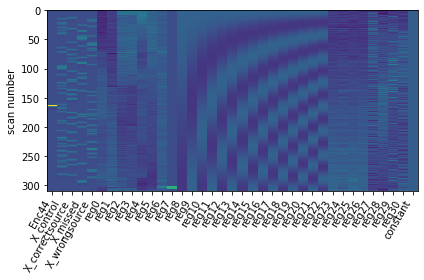

betas_sub122922_Trial066_Enc44.nii
067   CTL20   Index(['CTL20', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


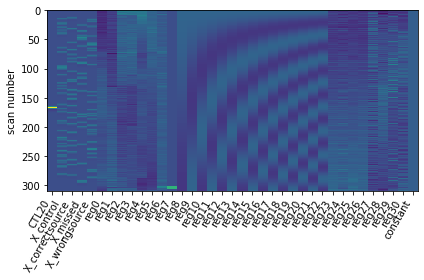

betas_sub122922_Trial067_CTL20.nii
068   CTL21   Index(['CTL21', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


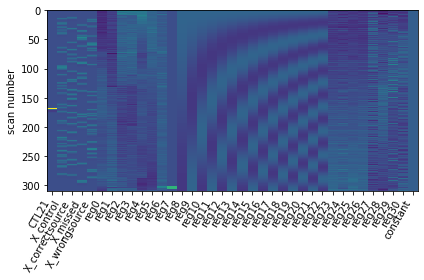

betas_sub122922_Trial068_CTL21.nii
069   Enc45   Index(['Enc45', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


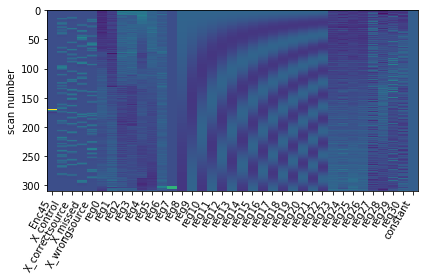

betas_sub122922_Trial069_Enc45.nii
070   CTL22   Index(['CTL22', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


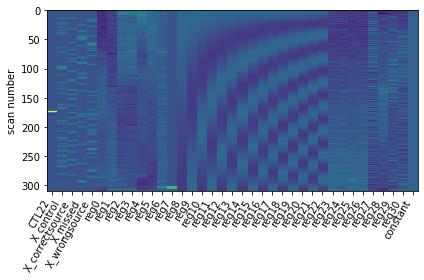

betas_sub122922_Trial070_CTL22.nii
071   Enc46   Index(['Enc46', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


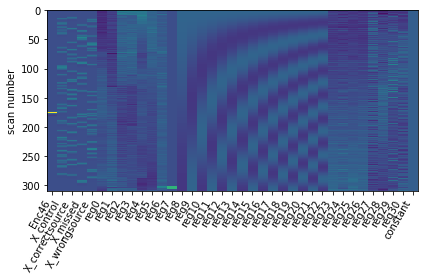

betas_sub122922_Trial071_Enc46.nii
072   Enc47   Index(['Enc47', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


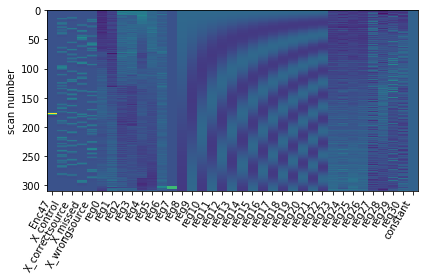

betas_sub122922_Trial072_Enc47.nii
073   Enc48   Index(['Enc48', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


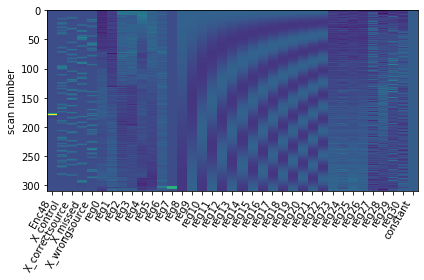

betas_sub122922_Trial073_Enc48.nii
074   Enc49   Index(['Enc49', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


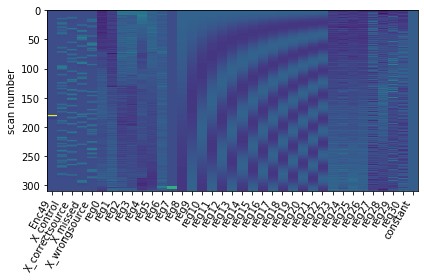

betas_sub122922_Trial074_Enc49.nii
075   Enc50   Index(['Enc50', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


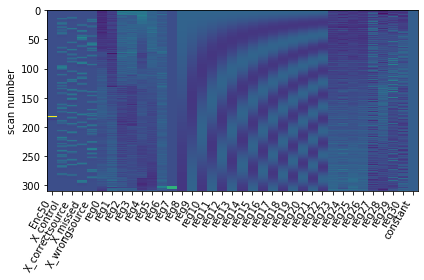

betas_sub122922_Trial075_Enc50.nii
076   Enc51   Index(['Enc51', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


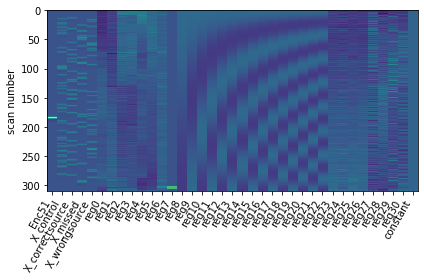

betas_sub122922_Trial076_Enc51.nii
077   Enc52   Index(['Enc52', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


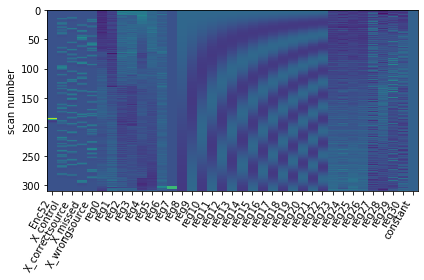

betas_sub122922_Trial077_Enc52.nii
078   CTL23   Index(['CTL23', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


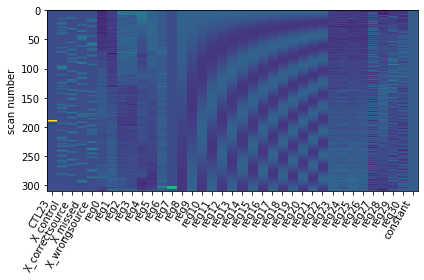

betas_sub122922_Trial078_CTL23.nii
079   Enc53   Index(['Enc53', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


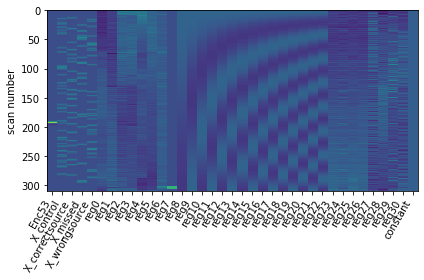

betas_sub122922_Trial079_Enc53.nii
080   CTL24   Index(['CTL24', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


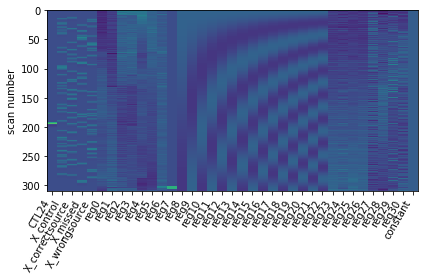

betas_sub122922_Trial080_CTL24.nii
081   Enc54   Index(['Enc54', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


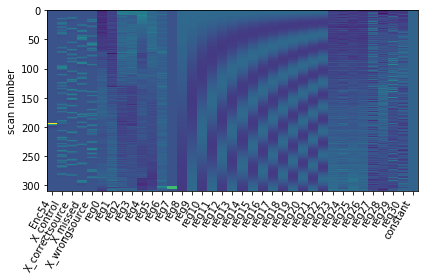

betas_sub122922_Trial081_Enc54.nii
082   Enc55   Index(['Enc55', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


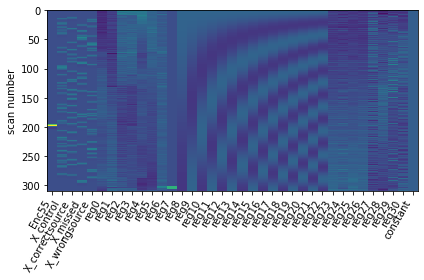

betas_sub122922_Trial082_Enc55.nii
083   Enc56   Index(['Enc56', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


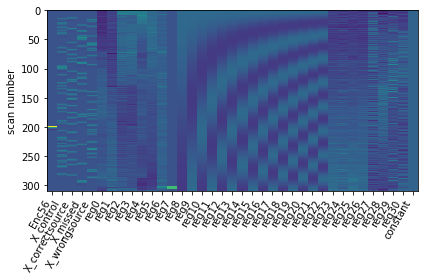

betas_sub122922_Trial083_Enc56.nii
084   Enc57   Index(['Enc57', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


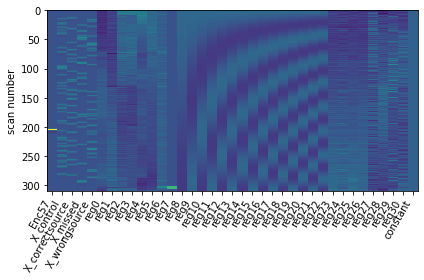

betas_sub122922_Trial084_Enc57.nii
085   CTL25   Index(['CTL25', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


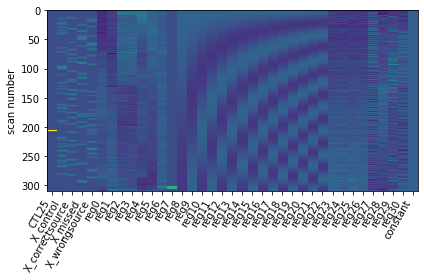

betas_sub122922_Trial085_CTL25.nii
086   Enc58   Index(['Enc58', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


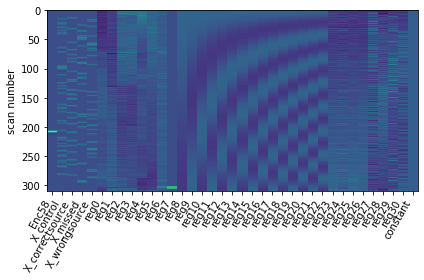

betas_sub122922_Trial086_Enc58.nii
087   Enc59   Index(['Enc59', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


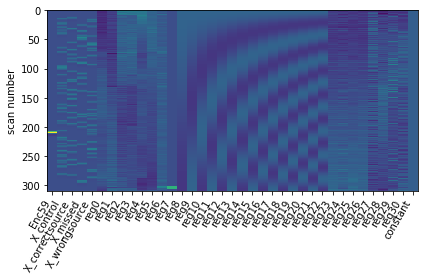

betas_sub122922_Trial087_Enc59.nii
088   Enc60   Index(['Enc60', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


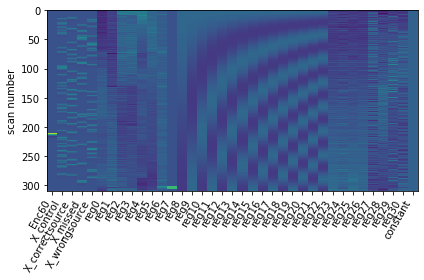

betas_sub122922_Trial088_Enc60.nii
089   CTL26   Index(['CTL26', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


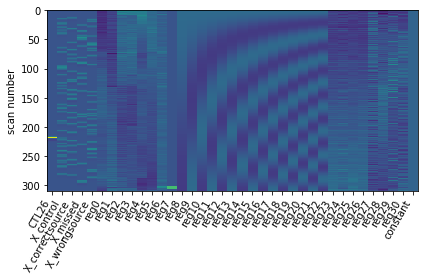

betas_sub122922_Trial089_CTL26.nii
090   CTL27   Index(['CTL27', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


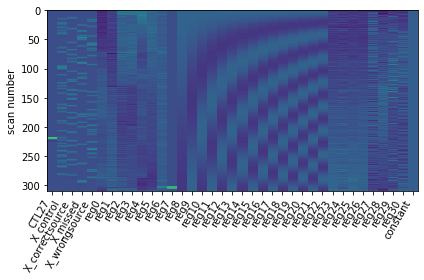

betas_sub122922_Trial090_CTL27.nii
091   CTL28   Index(['CTL28', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


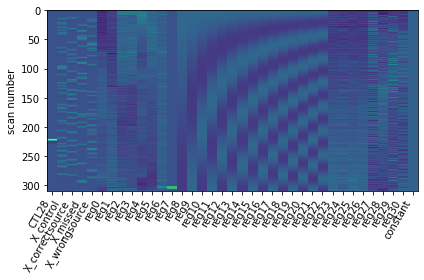

betas_sub122922_Trial091_CTL28.nii
092   Enc61   Index(['Enc61', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


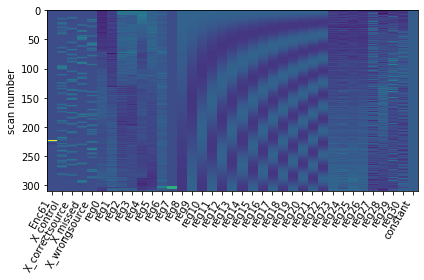

betas_sub122922_Trial092_Enc61.nii
093   Enc62   Index(['Enc62', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


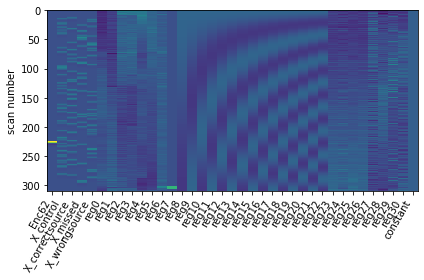

betas_sub122922_Trial093_Enc62.nii
094   CTL29   Index(['CTL29', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


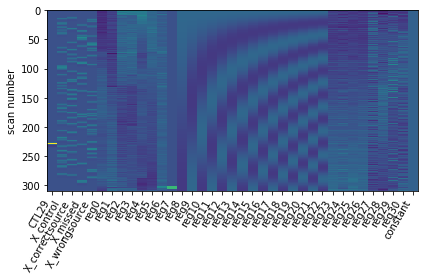

betas_sub122922_Trial094_CTL29.nii
095   Enc63   Index(['Enc63', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


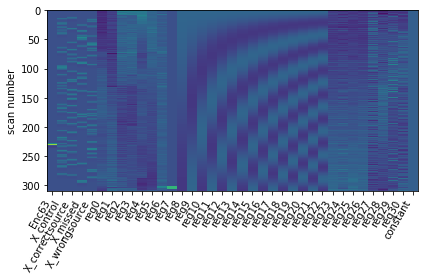

betas_sub122922_Trial095_Enc63.nii
096   Enc64   Index(['Enc64', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


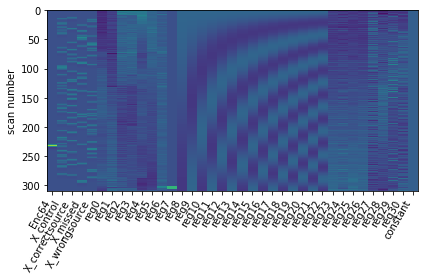

betas_sub122922_Trial096_Enc64.nii
097   CTL30   Index(['CTL30', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


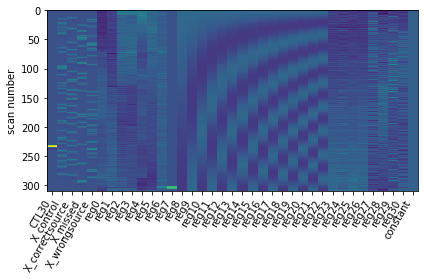

betas_sub122922_Trial097_CTL30.nii
098   Enc65   Index(['Enc65', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


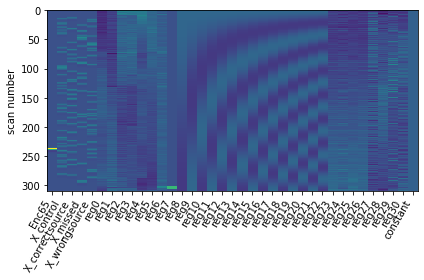

betas_sub122922_Trial098_Enc65.nii
099   Enc66   Index(['Enc66', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


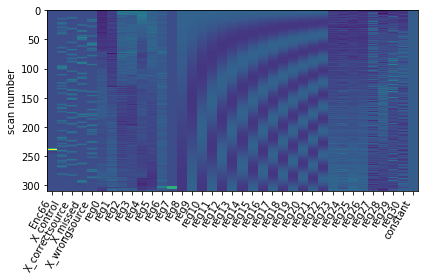

betas_sub122922_Trial099_Enc66.nii
100   CTL31   Index(['CTL31', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


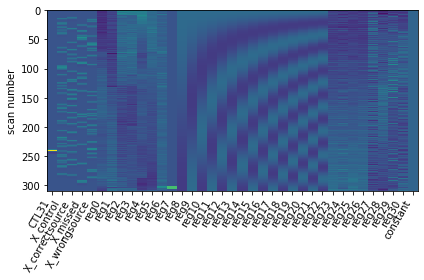

betas_sub122922_Trial100_CTL31.nii
101   CTL32   Index(['CTL32', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


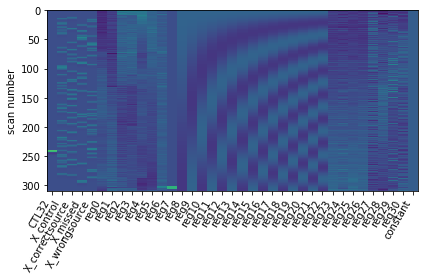

betas_sub122922_Trial101_CTL32.nii
102   Enc67   Index(['Enc67', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


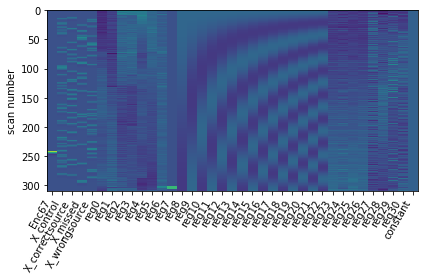

betas_sub122922_Trial102_Enc67.nii
103   Enc68   Index(['Enc68', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


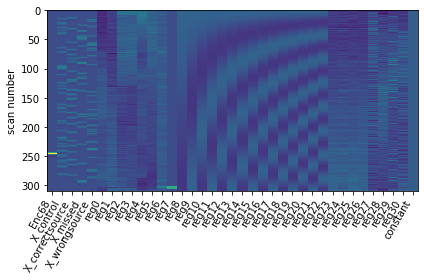

betas_sub122922_Trial103_Enc68.nii
104   CTL33   Index(['CTL33', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


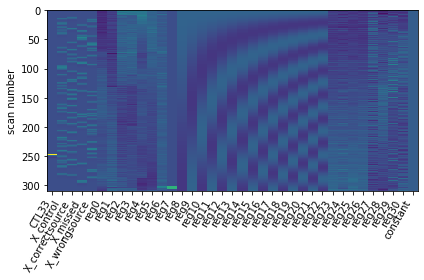

betas_sub122922_Trial104_CTL33.nii
105   CTL34   Index(['CTL34', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


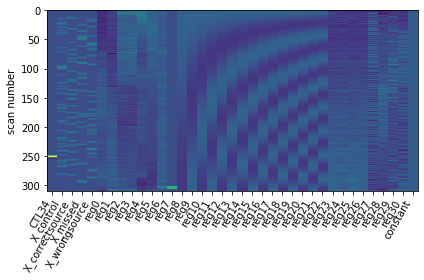

betas_sub122922_Trial105_CTL34.nii
106   Enc69   Index(['Enc69', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


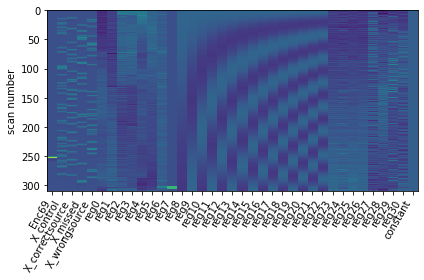

betas_sub122922_Trial106_Enc69.nii
107   Enc70   Index(['Enc70', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


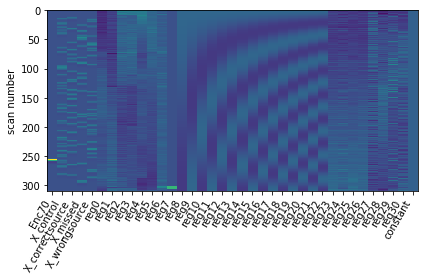

betas_sub122922_Trial107_Enc70.nii
108   CTL35   Index(['CTL35', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


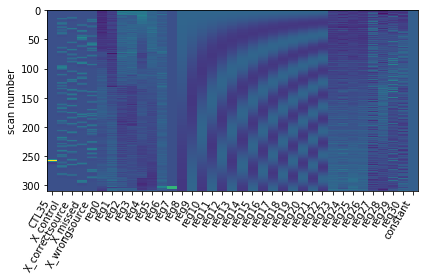

betas_sub122922_Trial108_CTL35.nii
109   CTL36   Index(['CTL36', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


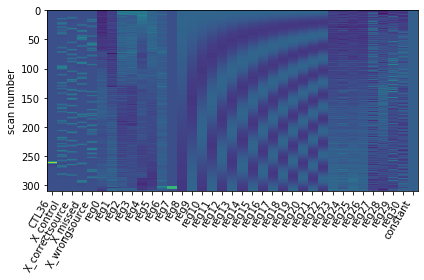

betas_sub122922_Trial109_CTL36.nii
110   Enc71   Index(['Enc71', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


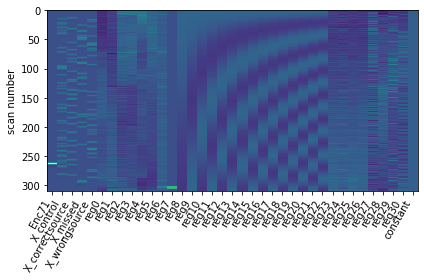

betas_sub122922_Trial110_Enc71.nii
111   Enc72   Index(['Enc72', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


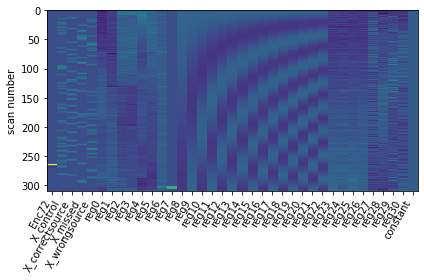

betas_sub122922_Trial111_Enc72.nii
112   CTL37   Index(['CTL37', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


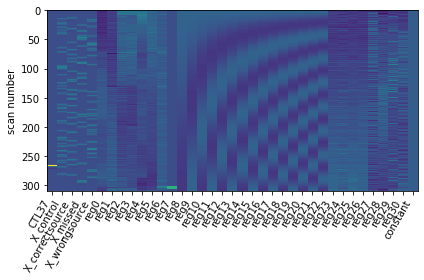

betas_sub122922_Trial112_CTL37.nii
113   CTL38   Index(['CTL38', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


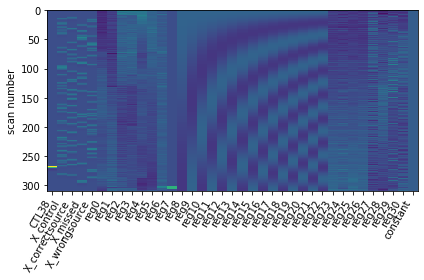

betas_sub122922_Trial113_CTL38.nii
114   Enc73   Index(['Enc73', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


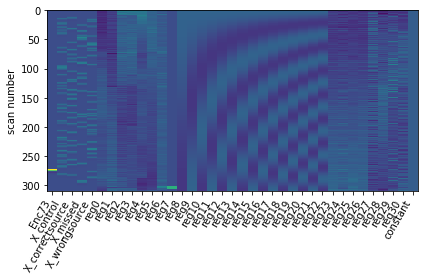

betas_sub122922_Trial114_Enc73.nii
115   Enc74   Index(['Enc74', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


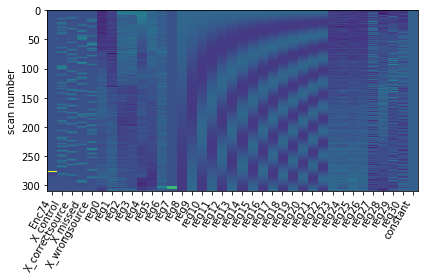

betas_sub122922_Trial115_Enc74.nii
116   CTL39   Index(['CTL39', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


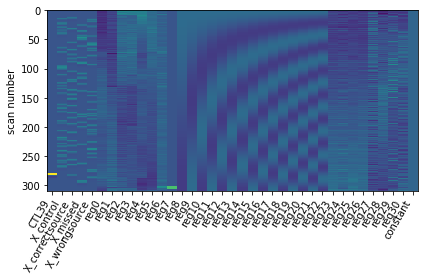

betas_sub122922_Trial116_CTL39.nii
117   Enc75   Index(['Enc75', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


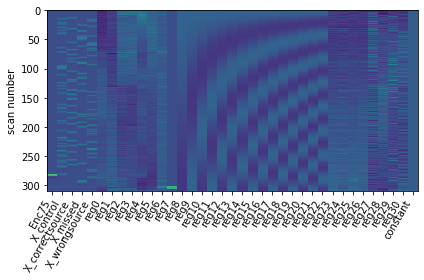

betas_sub122922_Trial117_Enc75.nii
118   Enc76   Index(['Enc76', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


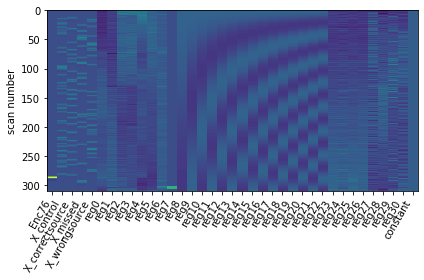

betas_sub122922_Trial118_Enc76.nii
119   Enc77   Index(['Enc77', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


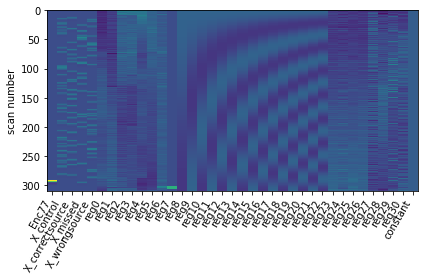

betas_sub122922_Trial119_Enc77.nii
120   Enc78   Index(['Enc78', 'X_control', 'X_correctsource', 'X_missed', 'X_wrongsource',
       'reg0'],
      dtype='object')


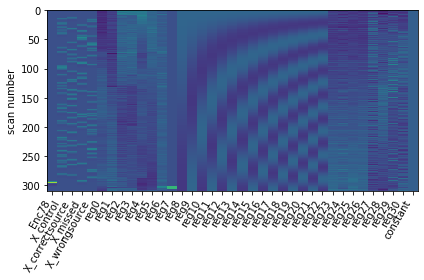

betas_sub122922_Trial120_Enc78.nii
(53, 64, 52, 117)


In [8]:
#where save outputted beta maps
outBeta_dir_A = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/OneModelPerTrial_4junkCondi'

#Define parameters related to image acquisition
tr = 2.5 #repetition time in seconds
n_scans = confounds.shape[0] #number of frames
frame_times = np.arange(n_scans)*tr # corresponding frame times for each epi scan

hrf_model = 'spm' #alternatives: 'glover', or 'spm + derivative'

##specify: path to preprocessed fMRI .nii file (gunzip it first!)
fmri_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/fMRI'
fmri_imgNS = glob.glob(os.path.join(fmri_dir, 'fmri_sub'+id+'*nii'))[0]

#Apply 8mm smoothing since using unsmoothed preprocessed data 
#taken from NIAK's "resample" output directory
fmri_img = image.smooth_img(fmri_imgNS, 8)

#117 trials if full scan (no missing frames)
numTrials = all_events.shape[0]

##
#This concatenation step might become obsolete, test Nilearn concatenation based on padded numbers!!
####
#Compile list of beta maps and their trial number, to be sorted by order of trial
all_betas_filelist_A = []
####

#Create a design matrix, first level model and beta map for each encoding and control trial 
for i in range (0, numTrials):

    #copy all_events dataframe to keep the original intact
    events = all_events.copy(deep = True)

    #Determine trial number and condition (encoding or control)
    tnum = events.iloc[i, 6]
    currentCondi = events.iloc[i, 3]
    tname = events.iloc[i, 2]
        
    #Version A: (2 conditions modelled separately)
    #modify trial_type column to model only the trial of interest 
    for j in events.index:
        if events.loc[j, 'trial_number'] != tnum:
            events.loc[j, 'trial_type']= 'X_'+ events.loc[j, 'ctl_miss_ws_cs']
            #X for condition to remain in alphabetical order: trial of interest, X_CTL, X_Enc
    #verify: what determines the order of columns in design matrix?    

    #remove unecessary columns
    cols = ['onset', 'duration', 'trial_type']
    events = events[cols]
    
    #create the model
    trial_model = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
                               hrf_model = hrf_model)    
    #Should data be standardized?

    #create the design matrix
    design = make_first_level_design_matrix(frame_times, events=events,
                                            drift_model=None, add_regs=confounds, 
                                            hrf_model=hrf_model)

    #fit model with design matrix
    trial_model = trial_model.fit(fmri_img, design_matrices = design)
    
    design_matrix = trial_model.design_matrices_[0]
    
    #sanity check: print design matrices and corresponding parameter labels
    #plot outputed design matrix for visualization
    print(str(tnum), ' ', tname, ' ', design_matrix.columns[0:6])
    plot_design_matrix(design_matrix)
    plt.show()

    #Contrast vector: 1 in design matrix column that corresponds to trial of interest, 0s elsewhere
    contrast_vec = np.repeat(0, design_matrix.shape[1])
    contrast_vec[0] = 1

    #compute the contrast's beta maps with the model.compute_contrast() method,
    #based on contrast provided. 
    #https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html
    b_map = trial_model.compute_contrast(contrast_vec, output_type='effect_size') #"effect_size" for betas
    b_name = os.path.join(outBeta_dir_A, 'betas_sub'+str(id)+'_Trial'+str(tnum)+'_'+tname+'.nii')
    #export b_map .nii image in output directory
    nibabel.save(b_map, b_name)
    print(os.path.basename(b_name))
    all_betas_filelist_A.append(b_name)
    
alltrials_betas_A = nibabel.funcs.concat_images(images=all_betas_filelist_A, check_affines=True, axis=None)
print(alltrials_betas_A.shape)
nibabel.save(alltrials_betas_A, os.path.join(outBeta_dir_A, 'concat_all_betas_sub'+str(id)+'.nii'))
    